In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("./data/train.csv", delimiter=";")
test = pd.read_csv("./data/test.csv", delimiter=";")

In [3]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
from sklearn.preprocessing import OneHotEncoder

X_train = train[["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]]
X_train = X_train.astype("category")

enc = OneHotEncoder()
X_train = enc.fit_transform(X_train)
y_train = train["y"]
y_train = y_train.astype("category")
#y_train = y_train.apply(lambda x: x.cat.codes)

X_test = test[["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]]
X_test = X_test.astype("category")
X_test = enc.transform(X_test)
y_test = test["y"]
y_test = y_test.astype("category")
#y_test = y_test.apply(lambda x: x.cat.codes)

In [6]:
y_train.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=0, max_depth=7)

clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [8]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

          no       0.99      0.90      0.94      4404
         yes       0.15      0.68      0.25       117

    accuracy                           0.89      4521
   macro avg       0.57      0.79      0.60      4521
weighted avg       0.97      0.89      0.93      4521



In [9]:
enc.get_feature_names(["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"])

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype=object)

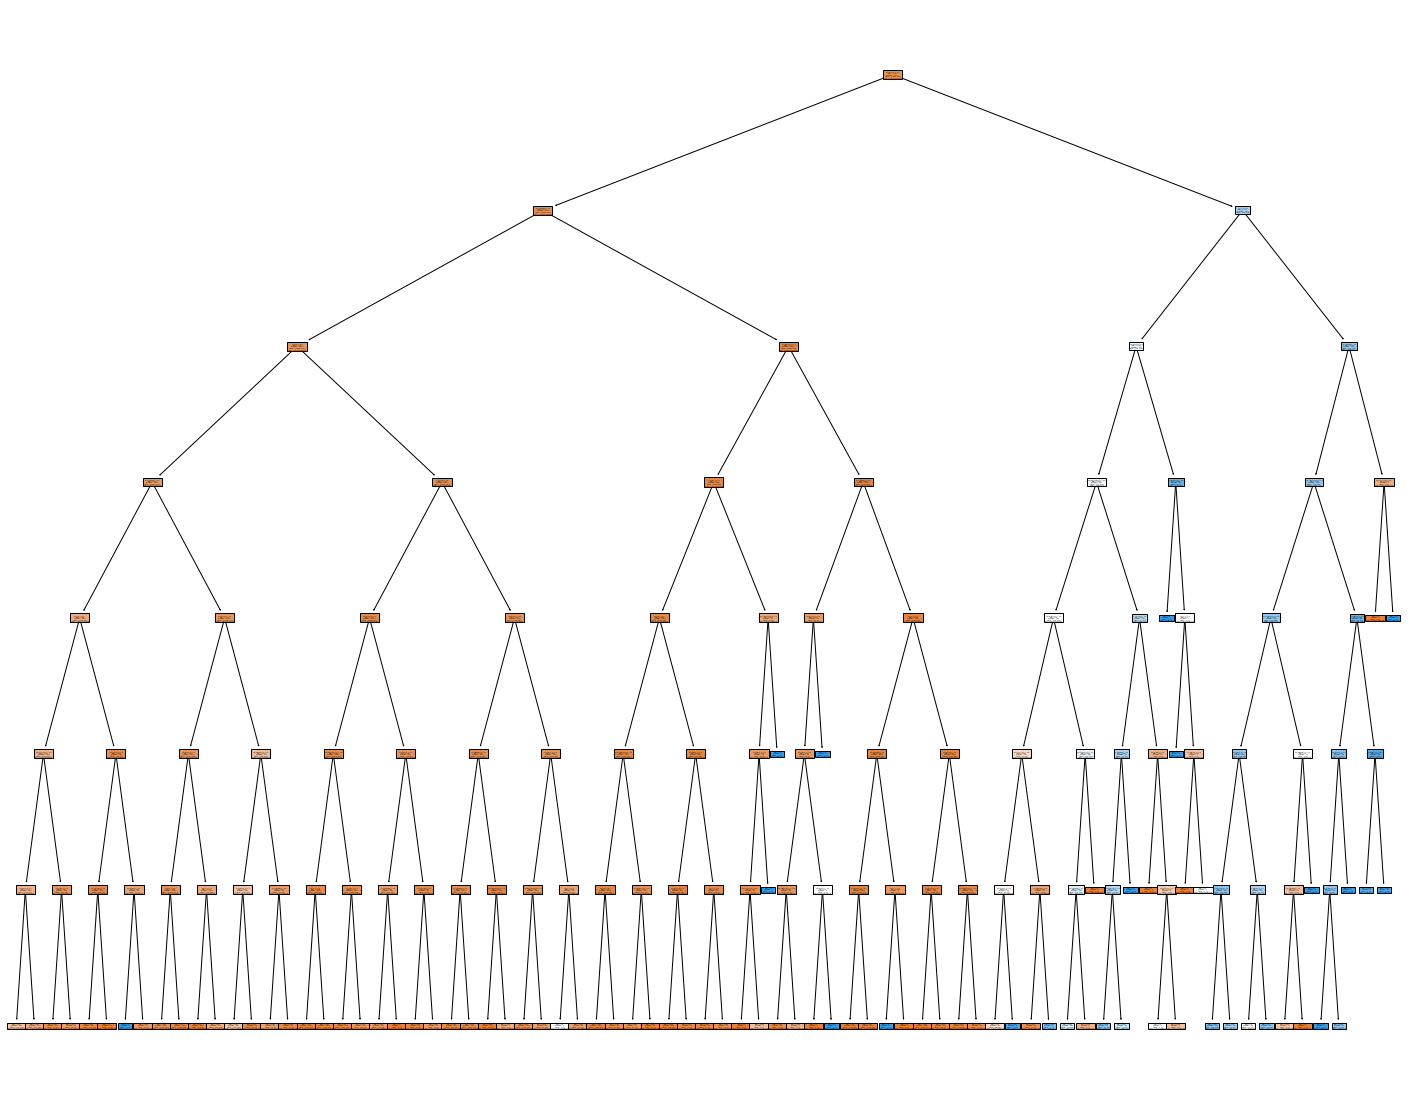

In [10]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=enc.get_feature_names(),  
                   class_names=["Did Not Subscribe", "Subscribed"],
                   filled=True)

In [11]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False


def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf
        if index!=len(path)-1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "({} == False) \t ".format(column_names[feature[node]])
            else:
                mask += "({} == True) \t ".format(column_names[feature[node]])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [12]:
leave_id = clf.apply(X_train)

paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], enc.get_feature_names(["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]))

In [13]:
for r in rules:
    if np.argmax(clf.tree_.value[r]):
        classification = "Subscribed"
    else:
        classification = "Did Not Subscribe"
    print(r, rules[r], "->", classification)

7 (poutcome_success == False) & (contact_unknown == False) & (housing_yes == False) & (poutcome_unknown == False) & (loan_yes == False) & (job_blue-collar == False) & (poutcome_failure == False)   -> Did Not Subscribe
8 (poutcome_success == False) & (contact_unknown == False) & (housing_yes == False) & (poutcome_unknown == False) & (loan_yes == False) & (job_blue-collar == False) & (poutcome_failure == True)   -> Did Not Subscribe
10 (poutcome_success == False) & (contact_unknown == False) & (housing_yes == False) & (poutcome_unknown == False) & (loan_yes == False) & (job_blue-collar == True) & (poutcome_other == False)   -> Did Not Subscribe
11 (poutcome_success == False) & (contact_unknown == False) & (housing_yes == False) & (poutcome_unknown == False) & (loan_yes == False) & (job_blue-collar == True) & (poutcome_other == True)   -> Did Not Subscribe
14 (poutcome_success == False) & (contact_unknown == False) & (housing_yes == False) & (poutcome_unknown == False) & (loan_yes == True

In [14]:
columnToVertex = {"job": "Employment", 
                  "marital": "MaritalStatus", 
                  "education": "Education", 
                  "default": "DefaultStatus", 
                  "housing": "Housing", 
                  "loan": "Loan", 
                  "contact": "Contact", 
                  "poutcome": "PreviousOutcome"
                 }

ruleAttrEdges = {
    "job": "RULE_FOR_EMPLOYMENT",
    "marital": "RULE_FOR_MARITAL_STATUS",
    "education": "RULE_FOR_EDUCATION",
    "default": "RULE_FOR_DEFAULT_STATUS",
    "housing": "RULE_FOR_HOUSING",
    "loan": "RULE_FOR_LOAN",
    "contact": "RULE_FOR_CONTACT",
    "poutcome": "RULE_FOR_PREVIOUS_OUTCOME"
}

In [15]:
clf.tree_.node_count

175

In [16]:
clf.tree_.children_left[0]

1

In [17]:
clf.tree_.children_right[0]

114

In [18]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

edges = []

featNames = enc.get_feature_names(["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"])

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        if np.argmax(clf.tree_.value[i]):
            classification = "Subscribed"
            edges.append(("SubRule", i, "RULE_LEADS_TO_OUTCOME", "Outcome", "yes"))
        else:
            classification = "Did Not Subscribe"
            edges.append(("SubRule", i, "RULE_LEADS_TO_OUTCOME", "Outcome", "no"))
        print("{space}node={node} is a leaf node with outcome {cls}".format(
            space=node_depth[i] * "\t", node=i, cls=classification))
    else:
        edges.append(("SubRule", i, "RULE_HAS_SUBRULE", "SubRule", children_left[i]))
        edges.append(("SubRule", i, "RULE_HAS_SUBRULE", "SubRule", children_right[i]))
        
        # Take Care of NOT rules (left in the tree)
        edges.append(("SubRule", "not_"+featNames[feature[i]].split("_")[1], ruleAttrEdges[featNames[feature[i]].split("_")[0]], columnToVertex[featNames[feature[i]].split("_")[0]], featNames[feature[i]].split("_")[1]))
        edges.append(("SubRule", children_left[i], "RULE_HAS_SUBRULE", "SubRule", "not_"+featNames[feature[i]].split("_")[1]))

        # Take Care of TRUE rules (right in the tree)
        edges.append(("SubRule", children_right[i], ruleAttrEdges[featNames[feature[i]].split("_")[0]], columnToVertex[featNames[feature[i]].split("_")[0]], featNames[feature[i]].split("_")[1]))

        print("{space}node={node} is a split node: "
              "go to node {left} if {feature} == False "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=featNames[feature[i]],
                  threshold=threshold[i],
                  right=children_right[i]))

The binary tree structure has 175 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if poutcome_success == False else to node 114.
	node=1 is a split node: go to node 2 if contact_unknown == False else to node 65.
		node=2 is a split node: go to node 3 if housing_yes == False else to node 34.
			node=3 is a split node: go to node 4 if poutcome_unknown == False else to node 19.
				node=4 is a split node: go to node 5 if loan_yes == False else to node 12.
					node=5 is a split node: go to node 6 if job_blue-collar == False else to node 9.
						node=6 is a split node: go to node 7 if poutcome_failure == False else to node 8.
							node=7 is a leaf node with outcome Did Not Subscribe
							node=8 is a leaf node with outcome Did Not Subscribe
						node=9 is a split node: go to node 10 if poutcome_other == False else to node 11.
							node=10 is a leaf node with outcome Did Not Subscribe
							node=11 is a leaf node with outcome Did Not Subscribe
					

In [19]:
df = pd.DataFrame(edges, columns=['SourceType', 'Source', 'EdgeType', 'TargetType', 'Target'], dtype=str)

In [20]:
df.head()

,SourceType,Source,EdgeType,TargetType,Target
0,SubRule,0,RULE_HAS_SUBRULE,SubRule,1
1,SubRule,0,RULE_HAS_SUBRULE,SubRule,114
2,SubRule,not_success,RULE_FOR_PREVIOUS_OUTCOME,PreviousOutcome,success
3,SubRule,1,RULE_HAS_SUBRULE,SubRule,not_success
4,SubRule,114,RULE_FOR_PREVIOUS_OUTCOME,PreviousOutcome,success


In [21]:
df.tail()

,SourceType,Source,EdgeType,TargetType,Target
518,SubRule,not_blue-collar,RULE_FOR_EMPLOYMENT,Employment,blue-collar
519,SubRule,173,RULE_HAS_SUBRULE,SubRule,not_blue-collar
520,SubRule,174,RULE_FOR_EMPLOYMENT,Employment,blue-collar
521,SubRule,173,RULE_LEADS_TO_OUTCOME,Outcome,no
522,SubRule,174,RULE_LEADS_TO_OUTCOME,Outcome,yes


In [25]:
def addRuleTypes(row):
    sourceRuleType = ""
    targetRuleType = ""
    if row["SourceType"] == "SubRule":
        if row["Source"] == "0":
            sourceRuleType = "ROOT"
        elif "_not" in row["Source"]:
            sourceRuleType = "NOT"
        else:
            sourceRuleType = "AND"
    if row["TargetType"] == "SubRule":
        if row["Target"] == "0":
            targetRuleType = "ROOT"
        elif "not_" in row["Target"]:
            targetRuleType = "NOT"
        else:
            targetRuleType = "AND"
    return sourceRuleType, targetRuleType

df["ruleTypes"] = df.apply(addRuleTypes, axis=1)
df[['SourceRuleType', 'TargetRuleType']] = pd.DataFrame(df['ruleTypes'].tolist(), index=df.index)
df.drop(columns=["ruleTypes"], inplace=True)

In [26]:
df.head()

,SourceType,Source,EdgeType,TargetType,Target,SourceRuleType,TargetRuleType
0,SubRule,0,RULE_HAS_SUBRULE,SubRule,1,ROOT,AND
1,SubRule,0,RULE_HAS_SUBRULE,SubRule,114,ROOT,AND
2,SubRule,not_success,RULE_FOR_PREVIOUS_OUTCOME,PreviousOutcome,success,AND,
3,SubRule,1,RULE_HAS_SUBRULE,SubRule,not_success,AND,NOT
4,SubRule,114,RULE_FOR_PREVIOUS_OUTCOME,PreviousOutcome,success,AND,


In [27]:
df.to_csv("./data/dTreeEdges.csv")